# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os

####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.9

"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
# LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 1000
# scheduler_patience_mapping = {"CIFAR10": 200, "CIFAR100": 200, "ImageNet2012": 30}

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 500
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"

if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_128_SGD_90'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  45000
- Length of Valid Set :  5000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if valid_data is not None:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
else:
    valid_dataloader = None

if test_data is not None:
    test_dataloader = DataLoader(
        test_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("test.transforms =", test_data.transform, test_dataloader.batch_size)
else:
    test_dataloader = None

train.transforms = Compose(
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
) 128
valid.transforms = ToTensor() 128
test.transforms = ToTensor() 128


## Confirm that the dataset is loaded properly

Shape of X [N, C, H, W]: torch.Size([128, 3, 32, 32])
mean of X tensor([0.5061, 0.4886, 0.4418])
Shape of y: torch.Size([128]) torch.int64


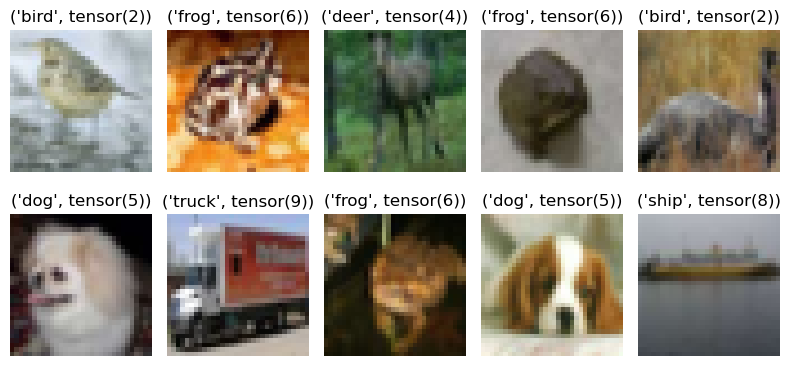

In [6]:
if test_data is not None:
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis("off")
            count += 1

            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="A"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


ResNet-32 for CIFAR10 is loaded.


In [9]:
# model.named_modules

In [10]:
# tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
# flops = FlopCountAnalysis(model, tmp_input)
# print(flop_count_table(flops))

# Define Training

## (1) Define Criterion

In [11]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [12]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [13]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_path=file_path)

## (4) Define Learning Rate schedualer

In [14]:
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode="min",
#     patience=scheduler_patience_mapping[DATASET],
#     factor=0.1,
#     verbose=True,
#     threshold=1e-4,
#     cooldown=100,
# )

scheduler = MultiStepLR(optimizer, milestones=[182, 91], gamma=0.1)
#
"""
=======================================================
non-split : milestones = [164, 81]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k : milestones = [182, 91]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nnon-split : milestones = [164, 81]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k : milestones = [182, 91]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\n'

## (5) Define AMP scaler

In [15]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [17]:
optimizer.param_groups[0]["lr"]

0.1

# [Training Loop]

In [18]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [25]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 248/1000] :


100%|██████████| 352/352 [00:19<00:00, 17.73it/s]


Train Loss: 0.0014 | Train Acc: 80.56%
Valid Loss: 0.6585 | Valid Acc: 77.90%
Test  Loss: 0.3936 | Test Acc: 86.93%
--------------------------------------------------
[Epoch 249/1000] :


100%|██████████| 352/352 [00:22<00:00, 15.84it/s]


Train Loss: 0.0014 | Train Acc: 84.72%
Valid Loss: 0.6653 | Valid Acc: 76.82%
Test  Loss: 0.3973 | Test Acc: 86.96%
--------------------------------------------------
[Epoch 250/1000] :


100%|██████████| 352/352 [00:23<00:00, 15.14it/s]


Train Loss: 0.0020 | Train Acc: 72.22%
Valid Loss: 0.6745 | Valid Acc: 78.04%
Test  Loss: 0.4085 | Test Acc: 86.93%
--------------------------------------------------
[Epoch 251/1000] :


100%|██████████| 352/352 [00:21<00:00, 16.10it/s]


Train Loss: 0.0010 | Train Acc: 88.89%
Valid Loss: 0.5824 | Valid Acc: 79.92%
Test  Loss: 0.3709 | Test Acc: 87.67%
--------------------------------------------------
[Epoch 252/1000] :


100%|██████████| 352/352 [00:23<00:00, 15.18it/s]


Train Loss: 0.0014 | Train Acc: 84.72%
Valid Loss: 0.6129 | Valid Acc: 79.46%
Test  Loss: 0.3415 | Test Acc: 88.61%
--------------------------------------------------
[Epoch 253/1000] :


100%|██████████| 352/352 [00:21<00:00, 16.04it/s]


Train Loss: 0.0018 | Train Acc: 69.44%
Valid Loss: 0.6761 | Valid Acc: 77.20%
Test  Loss: 0.3761 | Test Acc: 87.90%
--------------------------------------------------
[Epoch 254/1000] :


100%|██████████| 352/352 [00:25<00:00, 14.05it/s]


Train Loss: 0.0016 | Train Acc: 79.17%
Valid Loss: 0.6761 | Valid Acc: 76.80%
Test  Loss: 0.3911 | Test Acc: 86.93%
--------------------------------------------------
[Epoch 255/1000] :


100%|██████████| 352/352 [00:36<00:00,  9.70it/s]


Train Loss: 0.0014 | Train Acc: 84.72%
Valid Loss: 0.6382 | Valid Acc: 77.64%
Test  Loss: 0.3732 | Test Acc: 87.55%
--------------------------------------------------
[Epoch 256/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.90it/s]


Train Loss: 0.0012 | Train Acc: 87.50%
Valid Loss: 0.6118 | Valid Acc: 79.32%
Test  Loss: 0.3670 | Test Acc: 87.87%
--------------------------------------------------
[Epoch 257/1000] :


100%|██████████| 352/352 [00:35<00:00, 10.05it/s]


Train Loss: 0.0017 | Train Acc: 75.00%
Valid Loss: 0.7244 | Valid Acc: 75.96%
Test  Loss: 0.4321 | Test Acc: 85.77%
--------------------------------------------------
[Epoch 258/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.18it/s]


Train Loss: 0.0008 | Train Acc: 86.11%
Valid Loss: 0.6709 | Valid Acc: 77.46%
Test  Loss: 0.4355 | Test Acc: 86.03%
--------------------------------------------------
[Epoch 259/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.88it/s]


Train Loss: 0.0018 | Train Acc: 76.39%
Valid Loss: 0.6528 | Valid Acc: 78.06%
Test  Loss: 0.4026 | Test Acc: 86.74%
--------------------------------------------------
[Epoch 260/1000] :


100%|██████████| 352/352 [00:35<00:00, 10.01it/s]


Train Loss: 0.0012 | Train Acc: 87.50%
Valid Loss: 0.6392 | Valid Acc: 77.92%
Test  Loss: 0.4156 | Test Acc: 86.15%
--------------------------------------------------
[Epoch 261/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.84it/s]


Train Loss: 0.0018 | Train Acc: 77.78%
Valid Loss: 0.6609 | Valid Acc: 77.72%
Test  Loss: 0.4265 | Test Acc: 86.16%
--------------------------------------------------
[Epoch 262/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Train Loss: 0.0018 | Train Acc: 77.78%
Valid Loss: 0.6169 | Valid Acc: 78.96%
Test  Loss: 0.3246 | Test Acc: 89.18%
--------------------------------------------------
[Epoch 263/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.15it/s]


Train Loss: 0.0012 | Train Acc: 84.72%
Valid Loss: 0.7081 | Valid Acc: 75.88%
Test  Loss: 0.4407 | Test Acc: 85.26%
--------------------------------------------------
[Epoch 264/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.18it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.6079 | Valid Acc: 78.66%
Test  Loss: 0.3672 | Test Acc: 87.35%
--------------------------------------------------
[Epoch 265/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.18it/s]


Train Loss: 0.0017 | Train Acc: 81.94%
Valid Loss: 0.6697 | Valid Acc: 78.10%
Test  Loss: 0.3982 | Test Acc: 86.97%
--------------------------------------------------
[Epoch 266/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.11it/s]


Train Loss: 0.0018 | Train Acc: 73.61%
Valid Loss: 0.5971 | Valid Acc: 79.08%
Test  Loss: 0.3332 | Test Acc: 89.13%
--------------------------------------------------
[Epoch 267/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.13it/s]


Train Loss: 0.0019 | Train Acc: 75.00%
Valid Loss: 0.6049 | Valid Acc: 79.20%
Test  Loss: 0.3414 | Test Acc: 88.29%
--------------------------------------------------
[Epoch 268/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.94it/s]


Train Loss: 0.0014 | Train Acc: 80.56%
Valid Loss: 0.6323 | Valid Acc: 77.96%
Test  Loss: 0.3928 | Test Acc: 87.21%
--------------------------------------------------
[Epoch 269/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Train Loss: 0.0016 | Train Acc: 79.17%
Valid Loss: 0.6385 | Valid Acc: 79.36%
Test  Loss: 0.3309 | Test Acc: 89.13%
--------------------------------------------------
[Epoch 270/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.14it/s]


Train Loss: 0.0014 | Train Acc: 84.72%
Valid Loss: 0.6229 | Valid Acc: 79.02%
Test  Loss: 0.3468 | Test Acc: 88.45%
--------------------------------------------------
[Epoch 271/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Train Loss: 0.0019 | Train Acc: 76.39%
Valid Loss: 0.6506 | Valid Acc: 77.94%
Test  Loss: 0.3527 | Test Acc: 88.14%
--------------------------------------------------
[Epoch 272/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.08it/s]


Train Loss: 0.0015 | Train Acc: 80.56%
Valid Loss: 0.6313 | Valid Acc: 79.02%
Test  Loss: 0.3807 | Test Acc: 87.44%
--------------------------------------------------
[Epoch 273/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.93it/s]


Train Loss: 0.0011 | Train Acc: 88.89%
Valid Loss: 0.6900 | Valid Acc: 76.88%
Test  Loss: 0.4369 | Test Acc: 86.37%
--------------------------------------------------
[Epoch 274/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.07it/s]


Train Loss: 0.0012 | Train Acc: 84.72%
Valid Loss: 0.7663 | Valid Acc: 75.10%
Test  Loss: 0.4718 | Test Acc: 84.92%
--------------------------------------------------
[Epoch 275/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.09it/s]


Train Loss: 0.0015 | Train Acc: 86.11%
Valid Loss: 0.6362 | Valid Acc: 78.60%
Test  Loss: 0.3369 | Test Acc: 88.51%
--------------------------------------------------
[Epoch 276/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.27it/s]


Train Loss: 0.0019 | Train Acc: 77.78%
Valid Loss: 0.5942 | Valid Acc: 79.58%
Test  Loss: 0.3465 | Test Acc: 88.30%
--------------------------------------------------
[Epoch 277/1000] :


100%|██████████| 352/352 [00:35<00:00, 10.02it/s]


Train Loss: 0.0023 | Train Acc: 68.06%
Valid Loss: 0.6867 | Valid Acc: 77.02%
Test  Loss: 0.4671 | Test Acc: 85.31%
--------------------------------------------------
[Epoch 278/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.09it/s]


Train Loss: 0.0011 | Train Acc: 87.50%
Valid Loss: 0.6821 | Valid Acc: 76.70%
Test  Loss: 0.5131 | Test Acc: 83.73%
--------------------------------------------------
[Epoch 279/1000] :


100%|██████████| 352/352 [00:35<00:00, 10.03it/s]


Train Loss: 0.0013 | Train Acc: 86.11%
Valid Loss: 0.5982 | Valid Acc: 79.26%
Test  Loss: 0.3272 | Test Acc: 88.99%
--------------------------------------------------
[Epoch 280/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Train Loss: 0.0018 | Train Acc: 76.39%
Valid Loss: 0.6590 | Valid Acc: 76.96%
Test  Loss: 0.4239 | Test Acc: 85.74%
--------------------------------------------------
[Epoch 281/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Train Loss: 0.0018 | Train Acc: 81.94%
Valid Loss: 0.6143 | Valid Acc: 78.20%
Test  Loss: 0.3378 | Test Acc: 88.63%
--------------------------------------------------
[Epoch 282/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.07it/s]


Train Loss: 0.0015 | Train Acc: 79.17%
Valid Loss: 0.6707 | Valid Acc: 77.28%
Test  Loss: 0.3725 | Test Acc: 87.12%
--------------------------------------------------
[Epoch 283/1000] :


100%|██████████| 352/352 [00:35<00:00, 10.02it/s]


Train Loss: 0.0013 | Train Acc: 84.72%
Valid Loss: 0.6455 | Valid Acc: 78.42%
Test  Loss: 0.3878 | Test Acc: 87.23%
--------------------------------------------------
[Epoch 284/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.10it/s]


Train Loss: 0.0014 | Train Acc: 83.33%
Valid Loss: 0.6198 | Valid Acc: 79.12%
Test  Loss: 0.3861 | Test Acc: 87.74%
--------------------------------------------------
[Epoch 285/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Train Loss: 0.0011 | Train Acc: 84.72%
Valid Loss: 0.6380 | Valid Acc: 78.84%
Test  Loss: 0.3572 | Test Acc: 88.22%
--------------------------------------------------
[Epoch 286/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Train Loss: 0.0013 | Train Acc: 80.56%
Valid Loss: 0.6183 | Valid Acc: 79.58%
Test  Loss: 0.3530 | Test Acc: 88.01%
--------------------------------------------------
[Epoch 287/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.95it/s]


Train Loss: 0.0022 | Train Acc: 70.83%
Valid Loss: 0.6170 | Valid Acc: 79.08%
Test  Loss: 0.3687 | Test Acc: 87.87%
--------------------------------------------------
[Epoch 288/1000] :


100%|██████████| 352/352 [00:35<00:00, 10.03it/s]


Train Loss: 0.0014 | Train Acc: 81.94%
Valid Loss: 0.6676 | Valid Acc: 77.64%
Test  Loss: 0.3508 | Test Acc: 88.25%
--------------------------------------------------
[Epoch 289/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.17it/s]


Train Loss: 0.0013 | Train Acc: 86.11%
Valid Loss: 0.6185 | Valid Acc: 79.16%
Test  Loss: 0.4273 | Test Acc: 86.34%
--------------------------------------------------
[Epoch 290/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.10it/s]


Train Loss: 0.0017 | Train Acc: 76.39%
Valid Loss: 0.6722 | Valid Acc: 77.08%
Test  Loss: 0.4235 | Test Acc: 86.42%
--------------------------------------------------
[Epoch 291/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.12it/s]


Train Loss: 0.0011 | Train Acc: 84.72%
Valid Loss: 0.6267 | Valid Acc: 78.32%
Test  Loss: 0.3803 | Test Acc: 87.80%
--------------------------------------------------
[Epoch 292/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.25it/s]


Train Loss: 0.0020 | Train Acc: 75.00%
Valid Loss: 0.7305 | Valid Acc: 76.16%
Test  Loss: 0.4474 | Test Acc: 85.72%
--------------------------------------------------
[Epoch 293/1000] :


100%|██████████| 352/352 [00:35<00:00, 10.02it/s]


Train Loss: 0.0013 | Train Acc: 81.94%
Valid Loss: 0.6337 | Valid Acc: 78.46%
Test  Loss: 0.3607 | Test Acc: 87.90%
--------------------------------------------------
[Epoch 294/1000] :


100%|██████████| 352/352 [00:34<00:00, 10.26it/s]


Train Loss: 0.0011 | Train Acc: 81.94%
Valid Loss: 0.5895 | Valid Acc: 79.04%
Test  Loss: 0.3482 | Test Acc: 88.18%
--------------------------------------------------
[Epoch 295/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.85it/s]


Train Loss: 0.0018 | Train Acc: 77.78%
Valid Loss: 0.6796 | Valid Acc: 77.32%
Test  Loss: 0.3593 | Test Acc: 88.20%
--------------------------------------------------
[Epoch 296/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.78it/s]


Train Loss: 0.0014 | Train Acc: 80.56%
Valid Loss: 0.7212 | Valid Acc: 75.24%
Test  Loss: 0.4776 | Test Acc: 84.50%
--------------------------------------------------
[Epoch 297/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Train Loss: 0.0019 | Train Acc: 73.61%
Valid Loss: 0.6400 | Valid Acc: 78.04%
Test  Loss: 0.3848 | Test Acc: 87.29%
--------------------------------------------------
[Epoch 298/1000] :


100%|██████████| 352/352 [00:35<00:00, 10.01it/s]


Train Loss: 0.0012 | Train Acc: 87.50%
Valid Loss: 0.6709 | Valid Acc: 77.16%
Test  Loss: 0.4493 | Test Acc: 85.91%
--------------------------------------------------
[Epoch 299/1000] :


100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Train Loss: 0.0010 | Train Acc: 90.28%
Valid Loss: 0.6232 | Valid Acc: 78.64%
Test  Loss: 0.3640 | Test Acc: 88.03%
--------------------------------------------------
[Epoch 300/1000] :


 38%|███▊      | 132/352 [00:13<00:22,  9.83it/s]

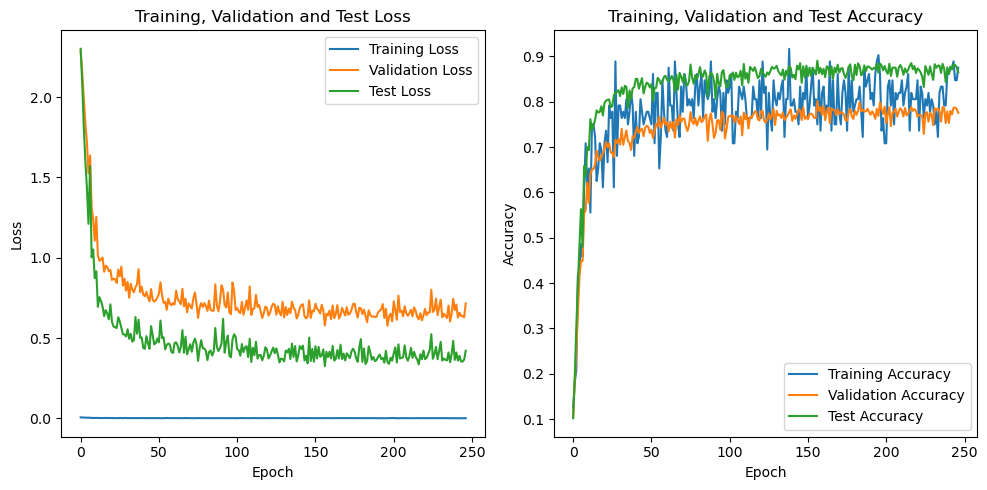

In [23]:
view = LogViewer(logs)
view.draw()

In [21]:
view.print_all()

1 epoch: train_loss=0.0065, train_acc=0.1250, test_loss=2.3008, test_acc=0.1020, valid_loss=2.2896, valid_acc=0.1044, lr=0.1000
2 epoch: train_loss=0.0059, train_acc=0.1806, test_loss=2.0855, test_acc=0.1916, valid_loss=2.1549, valid_acc=0.1806, lr=0.1000
3 epoch: train_loss=0.0060, train_acc=0.2083, test_loss=1.8122, test_acc=0.3017, valid_loss=1.9986, valid_acc=0.2488, lr=0.1000
4 epoch: train_loss=0.0045, train_acc=0.4167, test_loss=1.6018, test_acc=0.3969, valid_loss=1.8384, valid_acc=0.3298, lr=0.1000
5 epoch: train_loss=0.0043, train_acc=0.4306, test_loss=1.4358, test_acc=0.4802, valid_loss=1.7197, valid_acc=0.4128, lr=0.1000
6 epoch: train_loss=0.0045, train_acc=0.4861, test_loss=1.2111, test_acc=0.5632, valid_loss=1.5252, valid_acc=0.4486, lr=0.1000
7 epoch: train_loss=0.0037, train_acc=0.4583, test_loss=1.5710, test_acc=0.4800, valid_loss=1.6367, valid_acc=0.4486, lr=0.1000
8 epoch: train_loss=0.0027, train_acc=0.6111, test_loss=1.0035, test_acc=0.6577, valid_loss=1.3128, vali

In [22]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))